#### Colab setup

Run these commands if you are training the model on Colab. The whole repository needs to be uploaded to a Google Drive folder of your choice.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Change the following to the location of the uploaded repository:

In [ ]:
%cd "gdrive/My Drive/Colab Notebooks"  # changeme

#### Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from ipywidgets import IntSlider, interact, fixed

In [2]:
import common
import helpers
import processing.prune as prune
import processing.statistics as statistics
from architecture.layers import MaskedLinear, MaskedConv2d
from architecture.models import PruningModule, LeNet_20_100, LeNet_300_10, Conv2_30
from processing.snapshots import Snapshots
from data import get_mnist, get_cifar
from experiment import Experiment

In [3]:
def save_results(output_dir, layers):
    s = Snapshots(output_dir)
    fp_paths = {}
    ip_paths = {}
    norms_paths = {}
    graph_specs = {}
    for layer in layers:
        fp_path, ip_path, norms_path = s.save_computed_metrics(layer)
        fp_paths[layer] = fp_path
        ip_paths[layer] = ip_path
        norms_paths[layer] = norms_path
        graph_specs[layer] = s.create_adjacency(layer)
        
    return fp_paths, ip_paths, norms_paths, graph_specs

## Model selection

Two datasets can be used for training:
- MNIST
- CIFAR-10

A couple models are provided in `architecture.models`, but you are free to define you own model (see examples below). The only requirement is that you add it to `architecture.models` and import it in the notebook. Note that your model **must** inherit from `PruningModule`, and use only `MaskedLinear` and `MaskedConv2d` layers. You can also run one of the two provided setups, that load a dataset and a provided model.

### MNIST / Lenet 300-100-10

#### Loading the data

In [4]:
train_batch_size = 16
test_batch_size = 1000

In [5]:
trainloader, testloader, classes = get_mnist(train_batch_size, test_batch_size)

#### Specifying the model

In [4]:
from architecture.models import LeNet_300_100

In [5]:
model_class = LeNet_300_100
layers = ["fc1", "fc2", "fc3"]

In [6]:
epochs = 10
optim_kwargs = {"lr": 0.003, "momentum": 0.9}
criterion = nn.CrossEntropyLoss()
model = model_class(bias=False)
optimizer = optim.SGD(model.parameters(), **optim_kwargs)

### CIFAR-10 / Conv-2

#### Loading the data

In [ ]:
train_batch_size = 64
test_batch_size = 1000

In [ ]:
trainloader, testloader, classes = get_cifar(train_batch_size, test_batch_size)

#### Specifying the model

In [4]:
from architecture.models import Conv2

In [5]:
model_class = Conv2
layers = ["conv1", "conv2", "fc1", "fc2", "fc3"]

In [6]:
epochs = 10
optim_kwargs = {'lr': 0.0002}
criterion = nn.CrossEntropyLoss()
model = model_class(bias=False)
optimizer = optim.Adam(model.parameters(), **optim_kwargs)

## Run an experiment

Now that you have a dataset and a model (with a training objective and an optimizer), you can start an experiment, which allows you to train your model.

### Train the model

In [10]:
e = Experiment(model, criterion, optimizer, optim_kwargs)
test_accuracies = e.fit(trainloader, testloader, epochs, save_results=True)


Test set: Average loss: 2.3015, Accuracy:   1039/ 10000 (10%)

Created model directory: out/LeNet_300_100-unbiased-29_10_2019-09:42:41
Train Epoch:   1 [     0/ 60000 (0%)]	Loss: 2.288132
Train Epoch:   1 [  1600/ 60000 (3%)]	Loss: 0.837216
Train Epoch:   1 [  3200/ 60000 (5%)]	Loss: 0.574730
Train Epoch:   1 [  4800/ 60000 (8%)]	Loss: 0.551780
Train Epoch:   1 [  6400/ 60000 (11%)]	Loss: 0.115344
Train Epoch:   1 [  8000/ 60000 (13%)]	Loss: 0.678711
Train Epoch:   1 [  9600/ 60000 (16%)]	Loss: 0.334112
Train Epoch:   1 [ 11200/ 60000 (19%)]	Loss: 0.751553
Train Epoch:   1 [ 12800/ 60000 (21%)]	Loss: 0.420185
Train Epoch:   1 [ 14400/ 60000 (24%)]	Loss: 0.342685
Train Epoch:   1 [ 16000/ 60000 (27%)]	Loss: 0.184840
Train Epoch:   1 [ 17600/ 60000 (29%)]	Loss: 0.137155
Train Epoch:   1 [ 19200/ 60000 (32%)]	Loss: 0.112698
Train Epoch:   1 [ 20800/ 60000 (35%)]	Loss: 0.111357
Train Epoch:   1 [ 22400/ 60000 (37%)]	Loss: 0.187109
Train Epoch:   1 [ 24000/ 60000 (40%)]	Loss: 0.084129
Trai

### Look at the results

The second line of the output above should say _'Created model directory: '_. Assign this directory path to `output_dir`:

In [7]:
output_dir = "out/Conv2-unbiased-29_10_2019-09:01:19"  # changeme

Let's have a look at the training metrics, namely validation accuracy and frame potential (layer-wise):

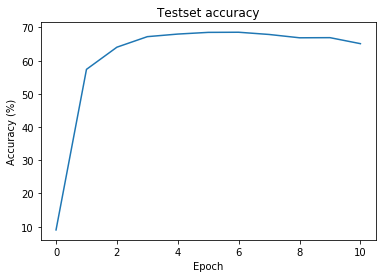

In [8]:
helpers.plot_test_acc(output_dir)

In [9]:
fp_paths, ip_paths, norms_paths, graph_specs = save_results(output_dir, layers)

Saved frame potentials to: out/Conv2-unbiased-29_10_2019-09:01:19/metrics/training/frame_potentials-conv1.npy
Saved inner products to: out/Conv2-unbiased-29_10_2019-09:01:19/metrics/training/inner_products-conv1.npy
Saved weight vector norms to: out/Conv2-unbiased-29_10_2019-09:01:19/metrics/training/weight_norms-conv1.npy
Saved adjacency matrix to: out/Conv2-unbiased-29_10_2019-09:01:19/metrics/training/adjacency-conv1.npy
Saved frame potentials to: out/Conv2-unbiased-29_10_2019-09:01:19/metrics/training/frame_potentials-conv2.npy
Saved inner products to: out/Conv2-unbiased-29_10_2019-09:01:19/metrics/training/inner_products-conv2.npy
Saved weight vector norms to: out/Conv2-unbiased-29_10_2019-09:01:19/metrics/training/weight_norms-conv2.npy
Saved adjacency matrix to: out/Conv2-unbiased-29_10_2019-09:01:19/metrics/training/adjacency-conv2.npy
Saved frame potentials to: out/Conv2-unbiased-29_10_2019-09:01:19/metrics/training/frame_potentials-fc1.npy
Saved inner products to: out/Conv2-u

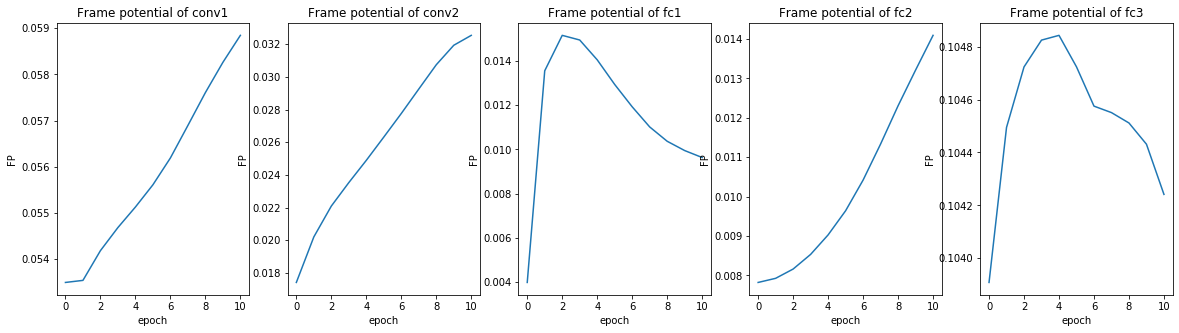

In [10]:
helpers.plot_train_fps(fp_paths, layers)

### Analysis of a layer

We will now focus on a single layer. The goal is to examine the evolution of the magnitudes of nodes (filters) and the cosine-distances between nodes (filters) during training.

In [11]:
layer = layers[3]  # e.g. conv1, fc1, fc2, etc.
weight_norms = np.load(norms_paths[layer])
adjacency, kernel_width = graph_specs[layer]

For given layer and epoch, we can compute the inner-product matrix, where the entry in the $i^{th}$ row, $j^{th}$ column corresponds to the inner-product of the normalized weight vectors associated to nodes (filters) $i$ and $j$. We use a gaussian kernel to compute the weights of an adjacency matrix that evolves in time, which will be used to define a graph in time (time being the range of epochs). The entries of this adjacency tensor have the following properties:

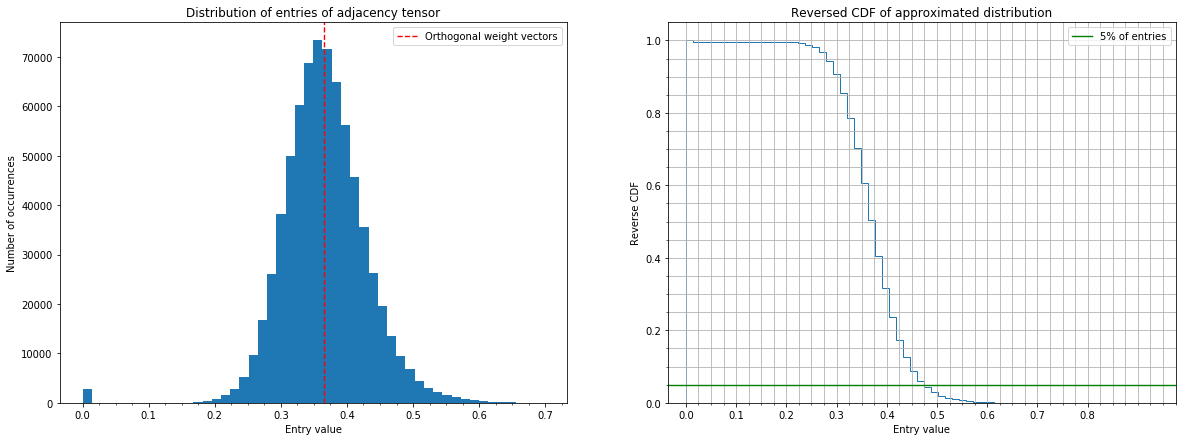

In [12]:
statistics.weight_dist(adjacency, kernel_width)

We choose a reasonable cut-off to sparsify the adjacency tensor.

In [13]:
min_cut_off = 0.45

Once the model is fully trained, we want to see how a cut-off affects the number of connected components:

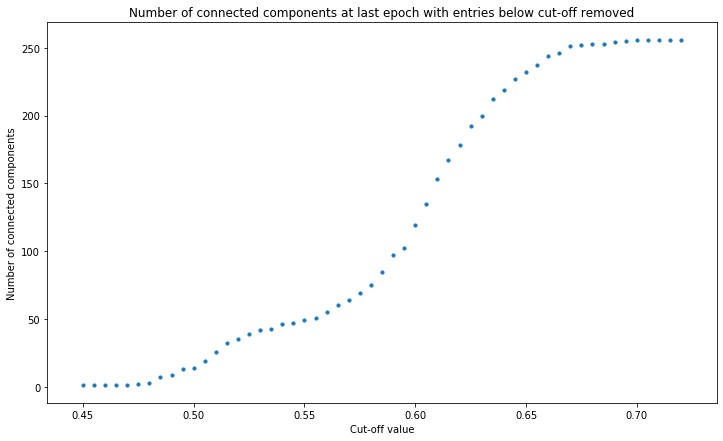

In [14]:
cut_offs = statistics.plot_connected_components(adjacency, min_cut_off)

Finally, we would like to find out how, for a given cut-off, the maximum magnitude of a node (filter) in a connected component relates to the size of the connected component.

In [15]:
plot_data = statistics.cc_max_norm(adjacency, weight_norms, cut_offs)
int_slider = IntSlider(value=0, min=0, max=len(plot_data)-1)
interact(statistics.cc_specs_plot, plot_data=fixed(plot_data), cut_offs=fixed(cut_offs), idx=int_slider);

interactive(children=(IntSlider(value=0, description='idx', max=54), Output()), _dom_classes=('widget-interact…

These plots help us choose a good cut-off, that can be used to visualize the evolution of the graph in time.

### Web visualization of training dynamics

The following code cell will start a webserver which will run indefinitely until you interrupt the Kernel.

In [16]:
import viz_main
viz_main.start(port=2019, use_reloader=False, debug=False)

 * Serving Flask app "viz_main" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://0.0.0.0:2019/ (Press CTRL+C to quit)
127.0.0.1 - - [29/Oct/2019 12:26:32] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [29/Oct/2019 12:26:41] "POST / HTTP/1.1" 302 -
127.0.0.1 - - [29/Oct/2019 12:26:41] "GET /params?base_dir=out%2FConv2-unbiased-29_10_2019-09%3A01%3A19 HTTP/1.1" 200 -
127.0.0.1 - - [29/Oct/2019 12:26:49] "POST /params?base_dir=out%2FConv2-unbiased-29_10_2019-09%3A01%3A19 HTTP/1.1" 302 -
127.0.0.1 - - [29/Oct/2019 12:26:50] "GET /result?base_dir=out%2FConv2-unbiased-29_10_2019-09%3A01%3A19&layer=fc1&var_base_dir=&cut_off=0.555 HTTP/1.1" 200 -


Visit the website here : [localhost:2019](http://localhost:2019)